In [7]:
# import packages

import os
import time
import warnings
import zipfile
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
!pip install missingno
import missingno as msno

warnings.filterwarnings('ignore')

# Data Load

In [8]:
# load data

DATA_DIR =  "/../Data/"

ds_names = (
    #"application_train", "application_test", 
    #"bureau", "bureau_balance", 
    #"credit_card_balance", "installments_payments",
    "previous_application","POS_CASH_balance","credit_card_balance"
)

datasets = {}

for ds_name in ds_names:
    datasets[ds_name] = pd.read_csv(os.getcwd() + DATA_DIR + f'{ds_name}.csv')

# EDA and Transformation Functions

In [9]:
# Class to summarize the features specified into min, max, mean, count, sum, median, and var
class FeatureSummarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
        self.agg_ops = ["min", "max", "count", "sum", "median", "mean", "var"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        keys = list(set(X.columns) - set(self.features))
        
        result = X.groupby(keys, as_index=False) \
                  .agg({ft:self.agg_ops for ft in self.features}) 
        result.columns = result.columns.map(lambda ct: '_'.join([x for x in ct if x != '']))
        
        return result 
    

def runFeatureSummarizer(df, features):
    print(f"df.shape: {df.shape}\n")
    print(f"Aggregated Features:\ndf[{features}][0:5]: \n{df[features][0:5]}")
    pipeline = make_pipeline(FeatureSummarizer(features))
    return(pipeline.fit_transform(df))


def id_num_cat_feature(df):
    numerical = df.select_dtypes(include=['int64', 'float64']).columns
    categorical = df.select_dtypes(include=['object', 'bool']).columns
    feat_num = list(numerical)
    feat_cat = list(categorical)
    
    id_cols = ['SK_ID_CURR','SK_ID_BUREAU']
    
    id_cols = [cols for cols in  list(df.columns.intersection(id_cols))] 
    features = list(set(df.columns) - set(id_cols))
    
    print('--------')
    print(f"# of ID's: {len(id_cols)}")
    print(f" ID's: {id_cols}")
    print('--------')
    print(f"# of numerical   features: {len(feat_num)}")
    print(f"Numerical   features: {feat_num}")
    print('--------')
    print(f"# of categorical features: {len(feat_cat)}")
    print(f"Categorical features: {feat_cat}")
    print('--------')
    print(f"# All features: {len(features)}")
    print(f"All features: {features}")
    return id_cols,feat_num,feat_cat,features

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 


def eda_transformation(df,n):

    id_cols, feat_num, feat_cat, features =  id_num_cat_feature(df)

    # One-Hot-Encode categorical variables
    df = pd.get_dummies(data=df, columns=feat_cat)

    features = list(set(df.columns) - set(id_cols))
    feat_ohe = list(set(features) - set(feat_num))

    print(f"# of OHE categorical features: {len(feat_ohe)}")
    print(f"OHE Categorical features: {feat_ohe}")
    print('--------')

    # aggregate bureau variables
    df = runFeatureSummarizer(df, features)

    if n ==3:
        
        feature_selection = [
            df[[column for column in df.columns if not column.startswith('SK_ID_PREV') and column.startswith(tuple(feat_num))]],
            df[[column for column in df.columns if column.startswith('DAYS') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith('SK_ID_PREV') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith(tuple(feat_cat)) and column.endswith(('mean', 'median', 'var'))]]
        ]
     
    if n ==4:
        
        feature_selection = [
            df[[column for column in df.columns if not column.startswith('SK_ID_PREV') and column.startswith(tuple(feat_num))]],
            df[[column for column in df.columns if column.startswith('SK_ID_PREV') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith(tuple(feat_cat)) and column.endswith(('mean', 'median', 'var'))]]
        ]

    df = pd.concat(feature_selection, axis=1)
    features = list(set(df.columns) - set(id_cols))

    print('--------')
    print('Aggregated Features:')
    print('\n'.join(map(str, sorted(features))))
    print('')
    print('Aggregated Data:')
    print('')
    print(df[features].describe().T)
    return df


def feature_selection(df,num):
    pass
    if feat_method == num:
        # bureau_balance
        feature_selection = [
            df[[column for column in df.columns if not column.startswith(tuple(feat_cat)) and not column.endswith('count')]],
            df[[column for column in df.columns if column.startswith('DAYS_CREDIT') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith(tuple(feat_cat)) and column.endswith(('mean', 'median', 'var'))]]
        ]

def drop_null_columns(df, threshold=0.7):
    # Dropping columns with missing value rate higher than threshold
    df = df[df.columns[df.isnull().mean() < threshold]]

    # Dropping rows with missing value rate higher than threshold
    df = df.loc[df.isnull().mean(axis=1) < threshold]

    return df 



# POS

In [10]:
def pos_eda(df):
    pos = df
    drop_list_pos = []
    
    #Adding new features

    pos['POS_PERC_INSTL_PNDNG']=pos['CNT_INSTALMENT_FUTURE']/pos['CNT_INSTALMENT']
    pos['POS_CNT_INSTAL_PNDNG']=pos['CNT_INSTALMENT']-pos['CNT_INSTALMENT_FUTURE']
    pos['POS_DAYS_WTHT_TOLRNC']=pos['SK_DPD']-pos['SK_DPD_DEF']
    pos['MONTHS_BALANCE'] = pos['MONTHS_BALANCE'].abs()
    
    #replacing " " with _ for OHE cols.
    pos['NAME_CONTRACT_STATUS']=pos['NAME_CONTRACT_STATUS'].apply(lambda x: str(x).replace(" ","_")) 
    
    # Drop elements ijndrop list
    threshold = 0.7

    #Dropping rows with missing value rate higher than threshold
    pos = pos.loc[pos.isnull().mean(axis=1) < threshold]
    
    return (eda_transformation(pos,4))

In [11]:
pos = datasets['POS_CASH_balance']
pos = pos_eda(pos)
#pos.to_csv(os.getcwd() + DATA_DIR + 'agg_pos.csv')

--------
# of ID's: 1
 ID's: ['SK_ID_CURR']
--------
# of numerical   features: 4
Numerical   features: ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'POS_PERC_INSTL_PNDNG', 'POS_CNT_INSTAL_PNDNG']
--------
# of categorical features: 1
Categorical features: ['NAME_CONTRACT_STATUS']
--------
# All features: 10
All features: ['POS_PERC_INSTL_PNDNG', 'CNT_INSTALMENT_FUTURE', 'POS_DAYS_WTHT_TOLRNC', 'NAME_CONTRACT_STATUS', 'CNT_INSTALMENT', 'POS_CNT_INSTAL_PNDNG', 'SK_DPD_DEF', 'MONTHS_BALANCE', 'SK_ID_PREV', 'SK_DPD']
# of OHE categorical features: 14
OHE Categorical features: ['POS_DAYS_WTHT_TOLRNC', 'NAME_CONTRACT_STATUS_Returned_to_the_store', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_XNA', 'NAME_CONTRACT_STATUS_Demand', 'SK_DPD_DEF', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS_Amortized_debt', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS_Active', 'SK_DPD']
--------
df.shape: (10001358, 19)


In [12]:
pos.head()

,CNT_INSTALMENT_min,CNT_INSTALMENT_max,CNT_INSTALMENT_count,CNT_INSTALMENT_sum,CNT_INSTALMENT_median,CNT_INSTALMENT_mean,CNT_INSTALMENT_var,POS_PERC_INSTL_PNDNG_min,POS_PERC_INSTL_PNDNG_max,POS_PERC_INSTL_PNDNG_count,...,NAME_CONTRACT_STATUS_Approved_var,NAME_CONTRACT_STATUS_Demand_median,NAME_CONTRACT_STATUS_Demand_mean,NAME_CONTRACT_STATUS_Demand_var,NAME_CONTRACT_STATUS_Amortized_debt_median,NAME_CONTRACT_STATUS_Amortized_debt_mean,NAME_CONTRACT_STATUS_Amortized_debt_var,NAME_CONTRACT_STATUS_Active_median,NAME_CONTRACT_STATUS_Active_mean,NAME_CONTRACT_STATUS_Active_var
0,4.0,4.0,9,36.0,4.0,4.000000,0.000000,0.00,1.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.777778,0.194444
1,24.0,24.0,19,456.0,24.0,24.000000,0.000000,0.25,1.0,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000
2,6.0,12.0,28,283.0,12.0,10.107143,7.876984,0.00,1.0,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.928571,0.068783
3,3.0,4.0,4,15.0,4.0,3.750000,0.250000,0.00,1.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.750000,0.250000
4,9.0,12.0,10,117.0,12.0,11.700000,0.900000,0.00,1.0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.818182,0.163636


# PREVAPP

In [13]:
def prevapp_eda(df):
    
    prevapp = df
    drop_list_pa = []
    #Day and Amount columns
    day_cols = [col for col in prevapp.columns if 'DAY' in col]
    amt_cols = [col for col in prevapp.columns if 'AMT' in col]
    #Adding new features

    prevapp['PREV_APRV_CNT'] = prevapp['NAME_CONTRACT_STATUS'].map(lambda x: 1 if (x == 'Approved') else 0)
    prevapp['PREV_REJ_CNT'] = prevapp['NAME_CONTRACT_STATUS'].map(lambda x: 1 if (x == 'Refused') else 0)
    prevapp['PREV_APCTN_CRDT_DIFF'] = prevapp['AMT_APPLICATION'] - prevapp['AMT_CREDIT']
    prevapp['PREV_APCTN_CRDT_RATIO'] = prevapp['AMT_APPLICATION'] / prevapp['AMT_CREDIT']
    prevapp['PREV_CRDT_ANNUTY_RATIO'] = prevapp['AMT_CREDIT']/prevapp['AMT_ANNUITY']
    prevapp['PREV_DWN_PYMNT_CRDT_RATIO'] = prevapp['AMT_DOWN_PAYMENT'] / prevapp['AMT_CREDIT']
    
    
    for c in [co for co in prevapp.columns if 'DAYS' in co]:
        prevapp[c] = prevapp[c].replace({365243.0: np.nan})
        prevapp[c] = prevapp[c].abs()
    
    drop_list_pa.append('WEEKDAY_APPR_PROCESS_START') ## weekday data is normally distributed, so wont make any sense to add that
    drop_list_pa.append('HOUR_APPR_PROCESS_START') ## Hour application started.
    
    
    
    # Drop elements ijndrop list

    drop_list_pa.append('WEEKDAY_APPR_PROCESS_START') ## weekday data is normally distributed, so wont make any sense to add that
    drop_list_pa.append('HOUR_APPR_PROCESS_START') ## Hour application started.

    threshold = 0.7
    drop_list_pa = list(prevapp.columns[prevapp.isnull().mean() > threshold])

    prevapp = prevapp.drop(columns=drop_list_pa, axis=1)

    #drop cols and rows which are more than 70% null
    #Dropping columns with missing value rate higher than threshold
    prevapp = prevapp[prevapp.columns[prevapp.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    prevapp = prevapp.loc[prevapp.isnull().mean(axis=1) < threshold]
    
    prevapp= eda_transformation(prevapp,3)
    return prevapp



In [14]:
prevapp = datasets['previous_application']
prevapp = prevapp_eda(prevapp)
#prevapp.to_csv(os.getcwd() + DATA_DIR + 'agg_prevapp.csv')

--------
# of ID's: 1
 ID's: ['SK_ID_CURR']
--------
# of numerical   features: 24
Numerical   features: ['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'PREV_APRV_CNT', 'PREV_REJ_CNT', 'PREV_APCTN_CRDT_DIFF', 'PREV_APCTN_CRDT_RATIO', 'PREV_CRDT_ANNUTY_RATIO', 'PREV_DWN_PYMNT_CRDT_RATIO']
--------
# of categorical features: 16
Categorical features: ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRO

In [15]:
#prevapp.SK_ID_PREV_count

# DF Summary

In [16]:
def feature_summary(df_fa):
    print('DataFrame shape')
    print('Rows:',df_fa.shape[0])
    print('Cols:',df_fa.shape[1])
    print("------------------------------------------------------------------------")
    
    col_list=['Null','%_Null','Unique_Count','Data_type','Max/Min','Mean','Std','Skewness','Sample_values']
    df=pd.DataFrame(index=df_fa.columns,columns=col_list)
    df['Null']=list([len(df_fa[col][df_fa[col].isnull()]) for i,col in enumerate(df_fa.columns)])
    df['%_Null']=round((df_fa.isnull().sum()/df_fa.isnull().count()*100),3).sort_values(ascending = False)
    df['Unique_Count']=list([len(df_fa[col].unique()) for i,col in enumerate(df_fa.columns)])
    df['Data_type']=list([df_fa[col].dtype for i,col in enumerate(df_fa.columns)])
    for i,col in enumerate(df_fa.columns):
        if 'float' in str(df_fa[col].dtype) or 'int' in str(df_fa[col].dtype):
            df.at[col,'Max/Min']=str(round(df_fa[col].max(),2))+'/'+str(round(df_fa[col].min(),2))
            df.at[col,'Mean']=df_fa[col].mean()
            df.at[col,'Std']=df_fa[col].std()
            df.at[col,'Skewness']=df_fa[col].skew()
        df.at[col,'Sample_values']=list(df_fa[col].unique())
    print("Table Statistics")
    print("------------------------------------------------------------------------")
    display(df.fillna('-'))
    #return(df.fillna('-'))


In [17]:
for i,ds_name in enumerate(datasets.keys()):
    print("Table under consideration:",ds_name.upper())
    print("------------------------------------------------------------------------")
    ds = feature_summary(datasets[ds_name])
    print("------------------------------------------------------------------------")
    

Table under consideration: PREVIOUS_APPLICATION
------------------------------------------------------------------------
DataFrame shape
Rows: 1670214
Cols: 43
------------------------------------------------------------------------
Table Statistics
------------------------------------------------------------------------


,Null,%_Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
SK_ID_PREV,0,0.000,1670214,int64,2845382/1000001,1923089.135331,532597.958696,-0.000573,"[2030495, 2802425, 2523466, 2819243, 1784265, ..."
SK_ID_CURR,0,0.000,338857,int64,456255/100001,278357.174099,102814.823849,-0.003303,"[271877, 108129, 122040, 176158, 202054, 19938..."
NAME_CONTRACT_TYPE,0,0.000,4,object,-,-,-,-,"[Consumer loans, Cash loans, Revolving loans, ..."
AMT_ANNUITY,372235,22.287,357960,float64,418058.15/0.0,15955.120659,14782.137335,2.692572,"[1730.43, 25188.615, 15060.735, 47041.335, 319..."
AMT_APPLICATION,0,0.000,93885,float64,6905160.0/0.0,175233.86036,292779.762387,3.391442,"[17145.0, 607500.0, 112500.0, 450000.0, 337500..."
AMT_CREDIT,1,0.000,86804,float64,6905160.0/0.0,196114.021218,318574.616546,3.245815,"[17145.0, 679671.0, 136444.5, 470790.0, 404055..."
AMT_DOWN_PAYMENT,895844,53.636,29279,float64,3060045.0/-0.9,6697.402139,20921.49541,36.476576,"[0.0, nan, 12649.5, 1350.0, 9000.0, 13500.0, 4..."
AMT_GOODS_PRICE,385515,23.082,93886,float64,6905160.0/0.0,227847.279283,315396.557937,3.07369,"[17145.0, 607500.0, 112500.0, 450000.0, 337500..."
WEEKDAY_APPR_PROCESS_START,0,0.000,7,object,-,-,-,-,"[SATURDAY, THURSDAY, TUESDAY, MONDAY, FRIDAY, ..."
HOUR_APPR_PROCESS_START,0,0.000,24,int64,23/0,12.484182,3.334028,-0.025629,"[15, 11, 7, 9, 8, 10, 12, 13, 14, 16, 6, 4, 5,..."


------------------------------------------------------------------------
Table under consideration: POS_CASH_BALANCE
------------------------------------------------------------------------
DataFrame shape
Rows: 10001358
Cols: 11
------------------------------------------------------------------------
Table Statistics
------------------------------------------------------------------------


,Null,%_Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
SK_ID_PREV,0,0.000,936325,int64,2843499/1000001,1903216.598957,535846.530722,0.044229,"[1803195, 1715348, 1784872, 1903291, 2341044, ..."
SK_ID_CURR,0,0.000,337252,int64,456255/100001,278403.863306,102763.74509,-0.003128,"[182943, 367990, 397406, 269225, 334279, 34216..."
MONTHS_BALANCE,0,0.000,96,int64,96/1,35.012588,26.06657,0.672777,"[31, 33, 32, 35, 38, 39, 34, 41, 37, 40, 43, 3..."
CNT_INSTALMENT,26071,0.261,74,float64,92.0/1.0,17.08965,11.995056,1.601734,"[48.0, 36.0, 12.0, 24.0, 60.0, 18.0, 4.0, 42.0..."
CNT_INSTALMENT_FUTURE,26087,0.261,80,float64,85.0/0.0,10.48384,11.109058,1.846746,"[45.0, 35.0, 9.0, 42.0, 12.0, 43.0, 36.0, 16.0..."
NAME_CONTRACT_STATUS,0,0.000,9,object,-,-,-,-,"[Active, Completed, Signed, Approved, Returned..."
SK_DPD,0,0.000,3400,int64,4231/0,11.606928,132.714043,14.899126,"[0, 1, 2, 4, 3, 18, 7, 5, 12, 6, 8, 13, 16, 10..."
SK_DPD_DEF,0,0.000,2307,int64,3595/0,0.654468,32.762491,66.339906,"[0, 1, 2, 4, 3, 18, 7, 5, 12, 8, 13, 10, 15, 6..."
POS_PERC_INSTL_PNDNG,26184,0.262,1280,float64,6.67/0.0,0.546994,0.330309,-0.24752,"[0.9375, 0.9722222222222222, 0.75, 0.875, 1.0,..."
POS_CNT_INSTAL_PNDNG,26184,0.262,120,float64,72.0/-51.0,6.605944,5.923767,1.667505,"[3.0, 1.0, 6.0, 0.0, 5.0, 8.0, 7.0, 9.0, 11.0,..."


------------------------------------------------------------------------
Table under consideration: CREDIT_CARD_BALANCE
------------------------------------------------------------------------
DataFrame shape
Rows: 3840312
Cols: 23
------------------------------------------------------------------------
Table Statistics
------------------------------------------------------------------------


,Null,%_Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
SK_ID_PREV,0,0.000,104307,int64,2843496/1000018,1904503.5899,536469.470563,0.038385,"[2562384, 2582071, 1740877, 1389973, 1891521, ..."
SK_ID_CURR,0,0.000,103558,int64,456250/100006,278324.207289,102704.475133,-0.001834,"[378907, 363914, 371185, 337855, 126868, 38001..."
MONTHS_BALANCE,0,0.000,96,int64,-1/-96,-34.521921,26.667751,-0.59804,"[-6, -1, -7, -4, -5, -3, -2, -19, -13, -18, -1..."
AMT_BALANCE,0,0.000,1347904,float64,1505902.19/-420250.18,58300.155262,106307.031025,2.920173,"[56.97, 63975.555, 31815.225, 236572.11, 45391..."
AMT_CREDIT_LIMIT_ACTUAL,0,0.000,181,int64,1350000/0,153807.9574,165145.699523,2.059732,"[135000, 45000, 450000, 225000, 270000, 585000..."
AMT_DRAWINGS_ATM_CURRENT,749816,19.525,2268,float64,2115000.0/-6827.31,5961.324822,28225.688579,9.664842,"[0.0, 2250.0, 67500.0, 45000.0, 90000.0, 76500..."
AMT_DRAWINGS_CURRENT,0,0.000,187005,float64,2287098.31/-6211.62,7433.388179,33846.077334,10.065626,"[877.5, 2250.0, 0.0, 11547.0, 67500.0, 45000.0..."
AMT_DRAWINGS_OTHER_CURRENT,749816,19.525,1833,float64,1529847.0/0.0,288.169582,8201.989345,50.57035,"[0.0, 137700.0, nan, 177840.0, 46800.0, 187200..."
AMT_DRAWINGS_POS_CURRENT,749816,19.525,168749,float64,2239274.16/0.0,2968.804848,20796.887047,19.421081,"[877.5, 0.0, 11547.0, 199339.425, 34526.7, 968..."
AMT_INST_MIN_REGULARITY,305236,7.948,312267,float64,202882.01/0.0,3540.204129,5600.154122,2.494431,"[1700.325, 2250.0, 11795.76, 22924.89, 4449.10..."


------------------------------------------------------------------------


# Credit Card Balance

In [1]:
def ccb_eda(df):
    ccb = df
    drop_list_ccb = []
    
    #Adding new features
    ccb['MONTHS_BALANCE'] = ccb['MONTHS_BALANCE'].abs()
    
    #replacing " " with _ for OHE cols.
    ccb['NAME_CONTRACT_STATUS']=ccb['NAME_CONTRACT_STATUS'].apply(lambda x: str(x).replace(" ","_")) 
    
    # Drop elements ijndrop list
    threshold = 0.7
    df = drop_null_columns(df, .7)

    #Dropping rows with missing value rate higher than threshold
    #ccb = ccb.loc[ccb.isnull().mean(axis=1) < threshold]
    
    return (eda_transformation(ccb,4))

ccb = datasets['credit_card_balance']
ccb = ccb_eda(ccb)

NameError: name 'datasets' is not defined

In [19]:
ccb = datasets['credit_card_balance']
ccb = ccb_eda(ccb)
#datasets_transformed['previous_application'] = prevapp.reset_index()

--------
# of ID's: 1
 ID's: ['SK_ID_CURR']
--------
# of numerical   features: 22
Numerical   features: ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF']
--------
# of categorical features: 1
Categorical features: ['NAME_CONTRACT_STATUS']
--------
# All features: 22
All features: ['AMT_DRAWINGS_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'CNT_DRAWINGS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'AMT_DRAWINGS_OTHER_CURRENT', 'NAME_CONTRACT_STATUS', 'CNT_DRAWINGS_OTHER_CURRENT', 'SK_DPD_DEF', 'AMT_CREDIT_LIMIT_ACTUAL', 'MONTHS_BALANCE', 'AMT_BALA

# Table Feature Visualization

In [3]:
def attr_type(df):
    return pd.value_counts(df.dtypes).sort_values().plot(kind="bar", figsize=(15, 8),logy=False,
                                              title="Type of features- Numerical/Categorical",
                                              ylabel="Number of features");

def unique_values(df_X):
    
    unique_values = df_X.select_dtypes(include="number").nunique().sort_values(ascending=False)
    # Plot information with y-axis in log-scale 
    # This is because distribution is highly skewed towards ID's. This will provide a fair idea about other features.
    unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

def percent_missing(df):
    df.isna().mean().sort_values().plot(kind="bar", figsize=(15, 8),logy=True,
                                          title="Percentage of missing values per feature",
                                          ylabel="Ratio of missing values per feature");
    
def categorical_count(df,categorical):
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(feat_cat):
        ax = plt.subplot(5, 4, i+1)
        sns.countplot(data=df[categorical], y=col, ax=ax,) 
    plt.suptitle('Category counts for all categorical variables')
    plt.tight_layout()
    plt.show()

def dendo(df):
    msno.dendrogram(df)
    
def numerical_features(df,num_cat):
    df[num_cat].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
              figsize=(15, 8), markersize=1);

def num_hist(df,features):
    df[features].hist(bins=25, figsize=(15, 8), layout=(-1, 5), edgecolor="black")
    plt.tight_layout();

    
def continous_features(df,feat_num):
    cols_continuous = df.select_dtypes(include="number").nunique() >= 25
    df_continuous = df[cols_continuous[cols_continuous].index]
    #df_continuous.shape
    sns.pairplot(df_continuous[feat_num], height=1.5, plot_kws={"s": 2, "alpha": 0.2});
    
def all_missing_values_plot(df):
    
    div = df.columns[df.isin([np.nan]).any()]
    display(msno.bar(df[div]).set_title("All features with missing data",fontsize=24))

Table under consideration: PREVIOUS_APPLICATION
------------------------------------------------------------------------
--------
# of ID's: 1
 ID's: ['SK_ID_CURR']
--------
# of numerical   features: 21
Numerical   features: ['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']
--------
# of categorical features: 16
Categorical features: ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHAN

Text(0.5, 1.0, 'All features with missing data')

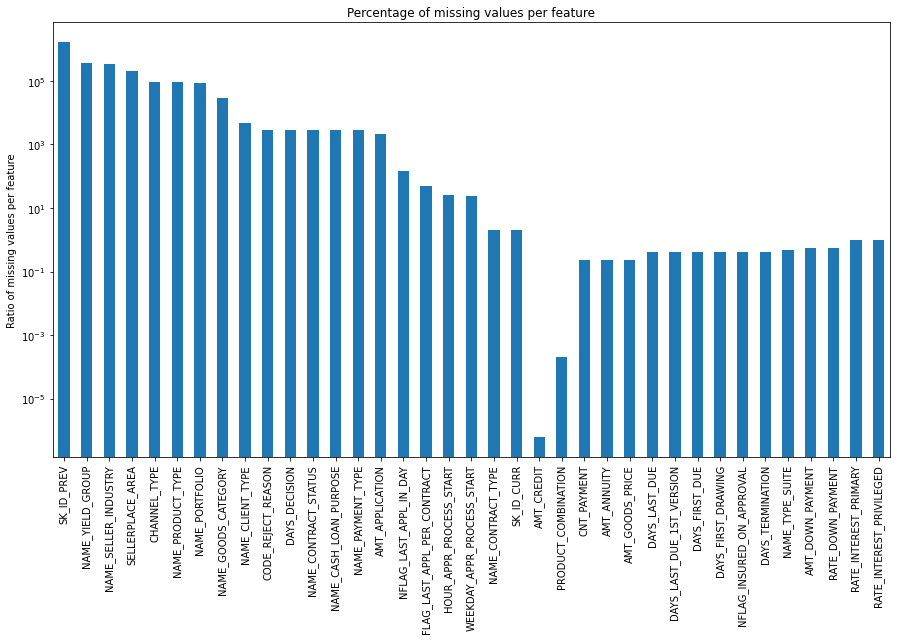

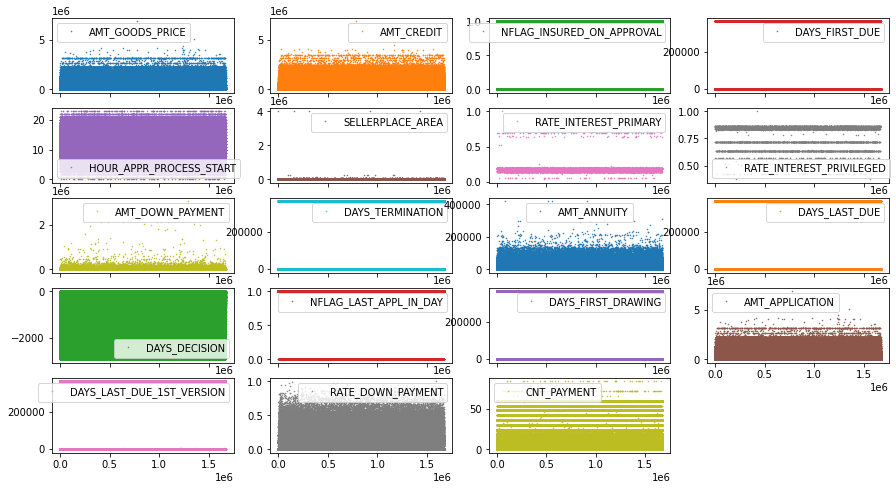

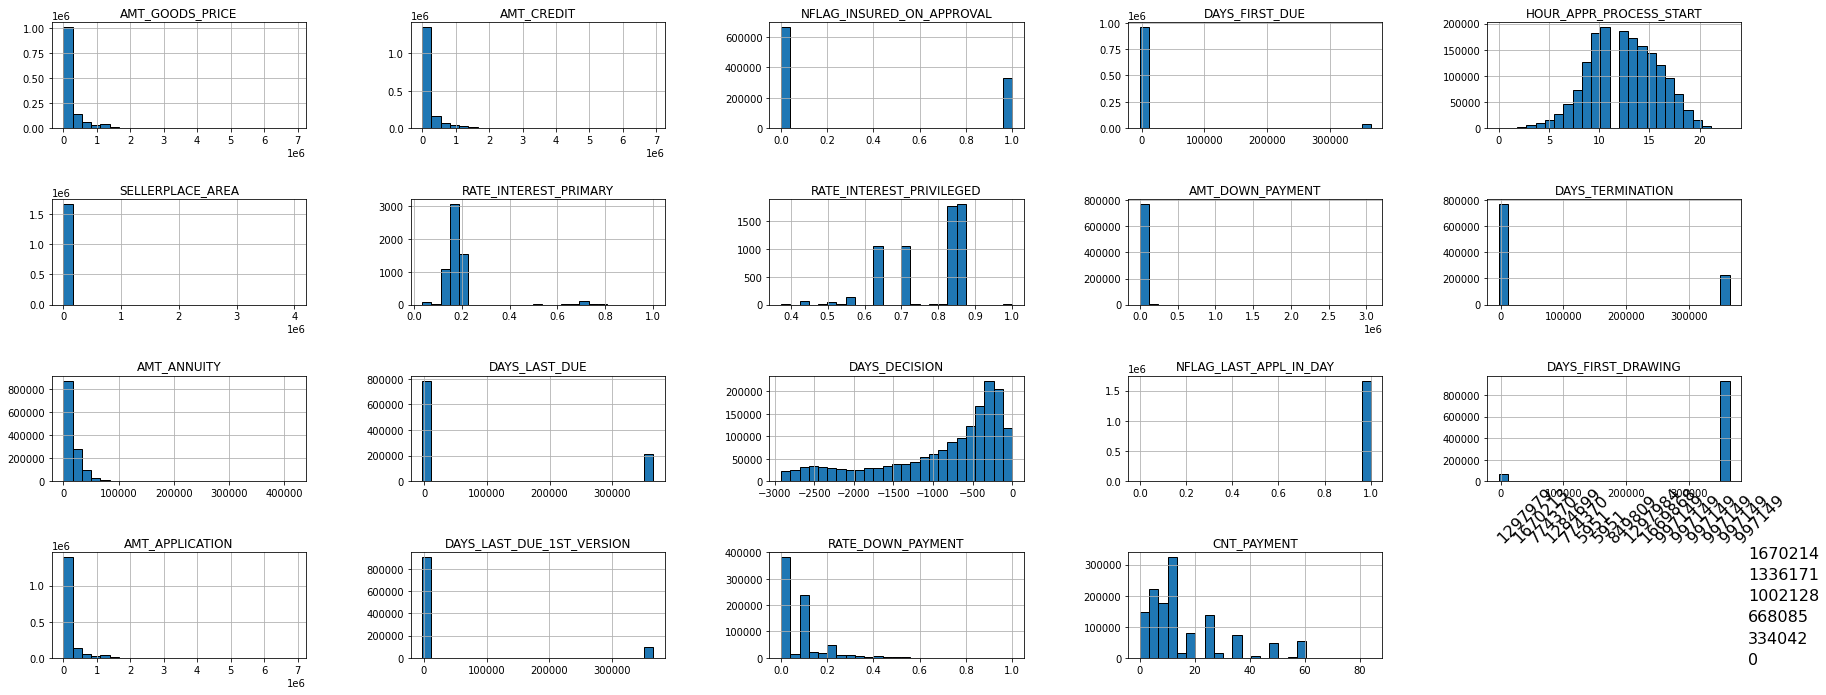

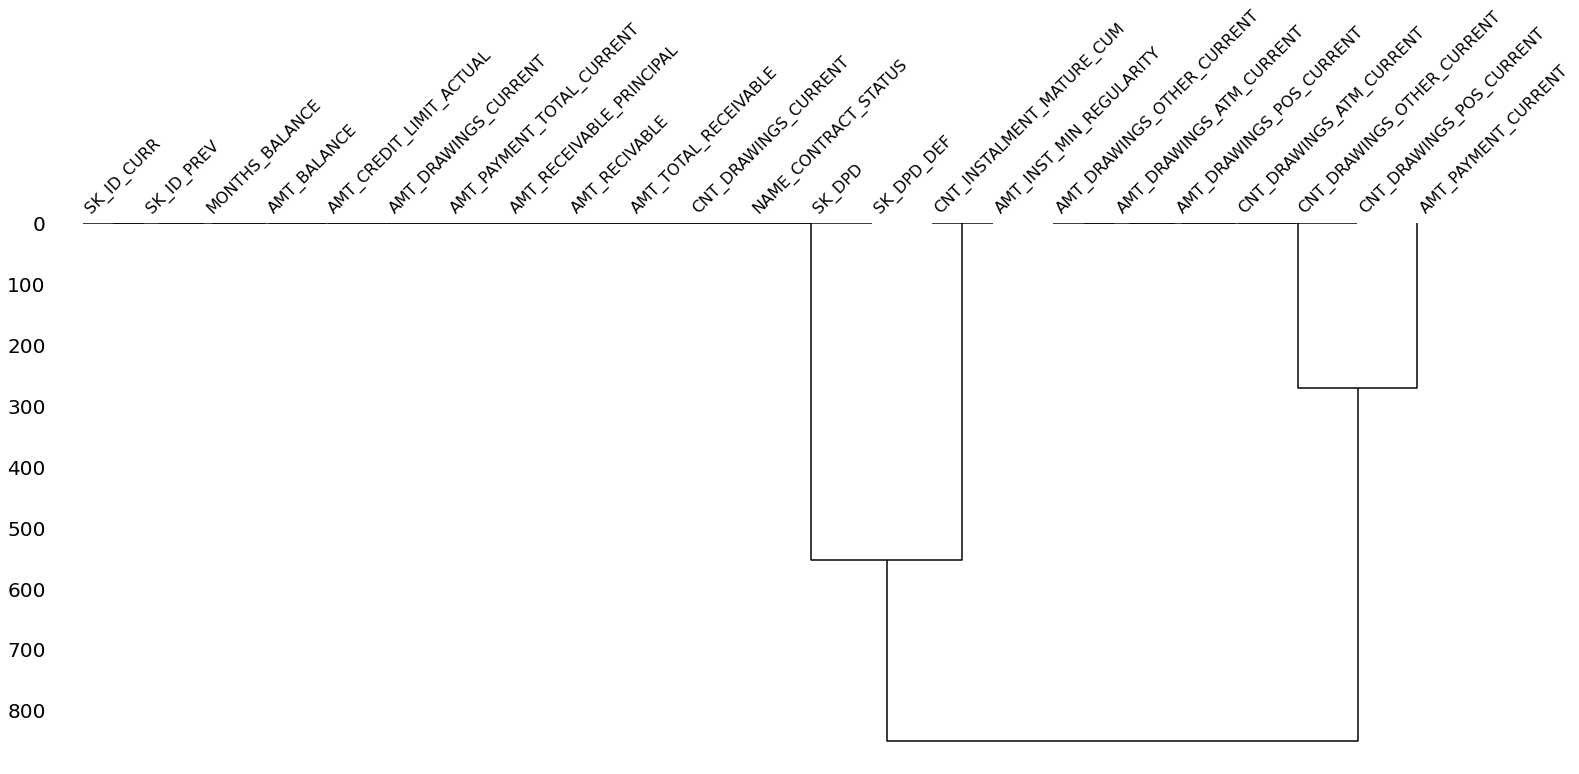

In [8]:
for i,ds_name in enumerate(datasets.keys()):
    
    #n = True
    #if n:
        
    if ds_name.upper() == 'PREVIOUS_APPLICATION':
        print("Table under consideration:",ds_name.upper())
        print("------------------------------------------------------------------------")
        id_cols, feat_num, feat_cat, features =  id_num_cat_feature(datasets[ds_name])
        only_num_cat = list(set(feat_num)-set(['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']))
        

        print("------------------------------------------------------------------------")
        print("-------------------------Type of Features-------------------------------")
        attr_type(datasets[ds_name])
        print("------------------------------------------------------------------------")
        print("-------------------------UNIQUE VALUES----------------------------------")
        unique_values(datasets[ds_name]) 
        print("------------------------------------------------------------------------")
        print("-------------------------MISSING PERCENTAGE-----------------------------")
        percent_missing(datasets[ds_name])
        print("------------------------------------------------------------------------")
        print("-------------------------CATEGORICAL COUNT------------------------------")
        #categorical_count(datasets[ds_name],feat_cat)
        print("------------------------------------------------------------------------")
        print("-------------------------NUM FEATURES-DOT-------------------------------")
        numerical_features(datasets[ds_name],only_num_cat)
        print("------------------------------------------------------------------------")
        print("-------------------------NUM FEATURES - HISTOGRAM ----------------------")
        num_hist(datasets[ds_name],only_num_cat)
        print("------------------------------------------------------------------------")
        print("-------------------------Continous Features ----------------------------")
        #continous_features(df_x,only_num_cat)
        print("------------------------------------------------------------------------")
        print("-------------------------All Missing Features---------------------------")
        all_missing_values_plot(datasets[ds_name])


#dendogram; sgroups together columns that have strong correlations in nullity.
#If a number of columns are grouped together at level zero, then the presence 
#of nulls in one of those columns is directly related to the presence or absence
#of nulls in the others columns. The more separated the columns in the tree, 
#the less likely the null values can be correlated between the columns.
dendo(datasets[ds_name])


## Correlation Plots Maps

In [24]:
# Numerical Variables
def corr_plot(data, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    if len(remove) > 0:
        num_cols2 = [x for x in data.columns if (x not in remove)]

    sns.set(font_scale=1.1)
    c = data[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()

------------------------------------------------------------------------
Table under consideration FOR CORRELATION PLOT: PREVIOUS_APPLICATION


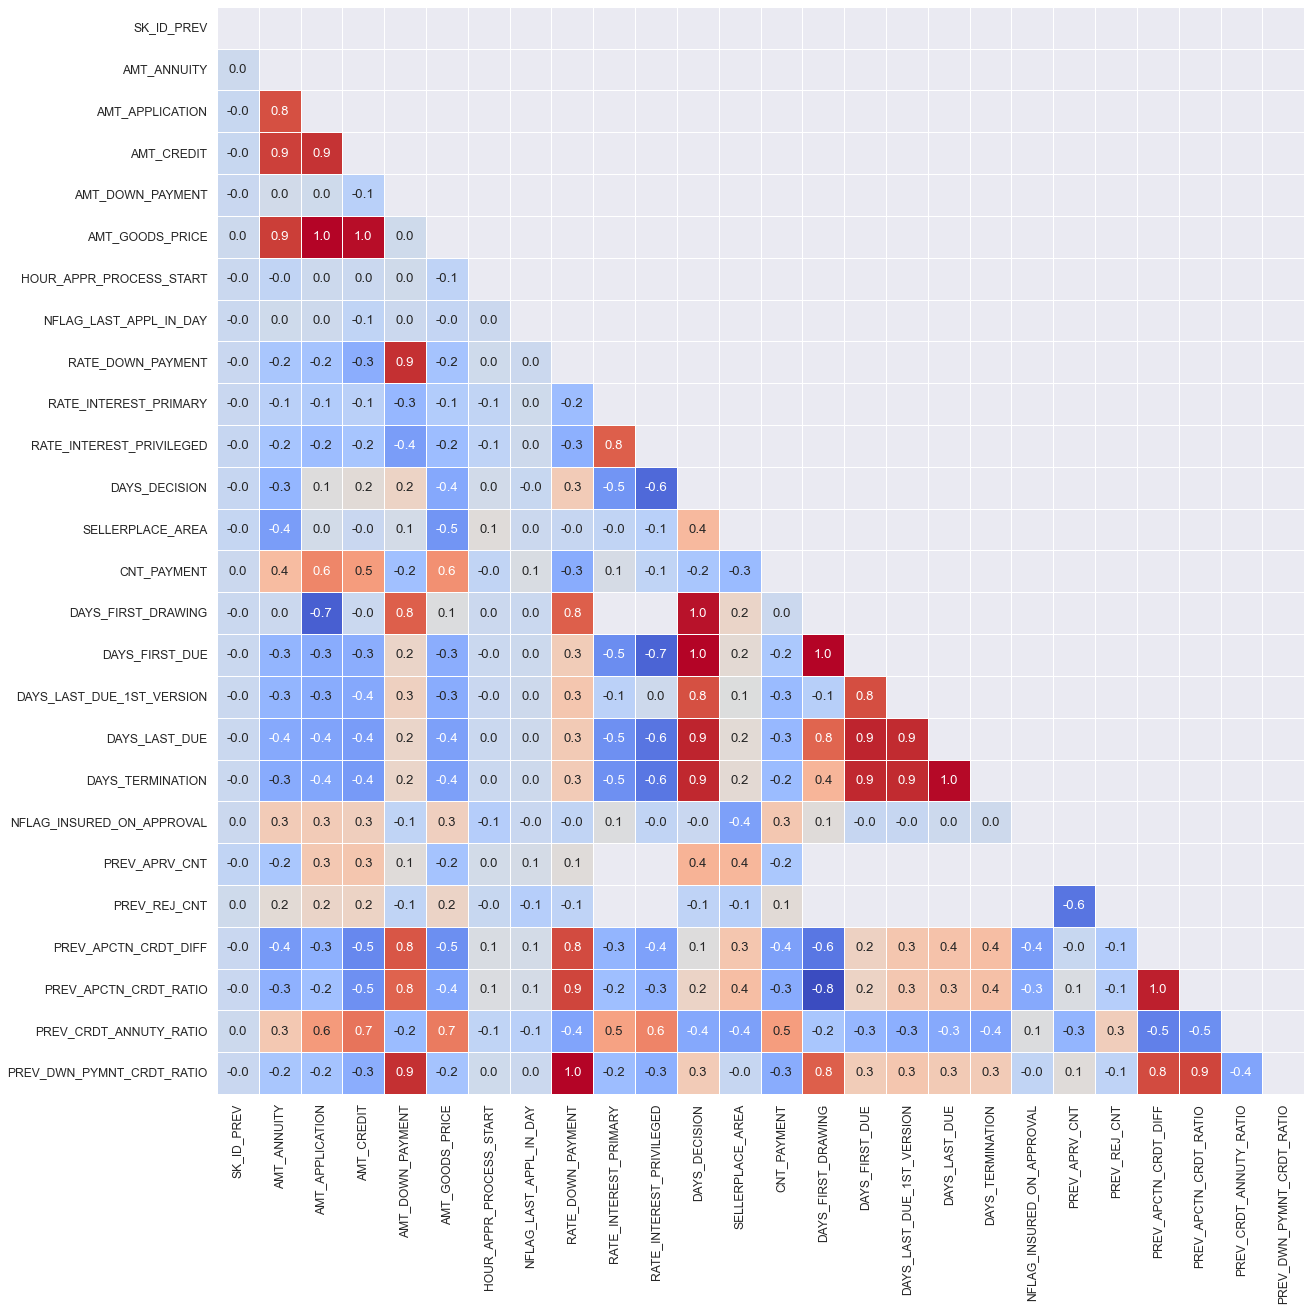

------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
Table under consideration FOR CORRELATION PLOT: POS_CASH_BALANCE


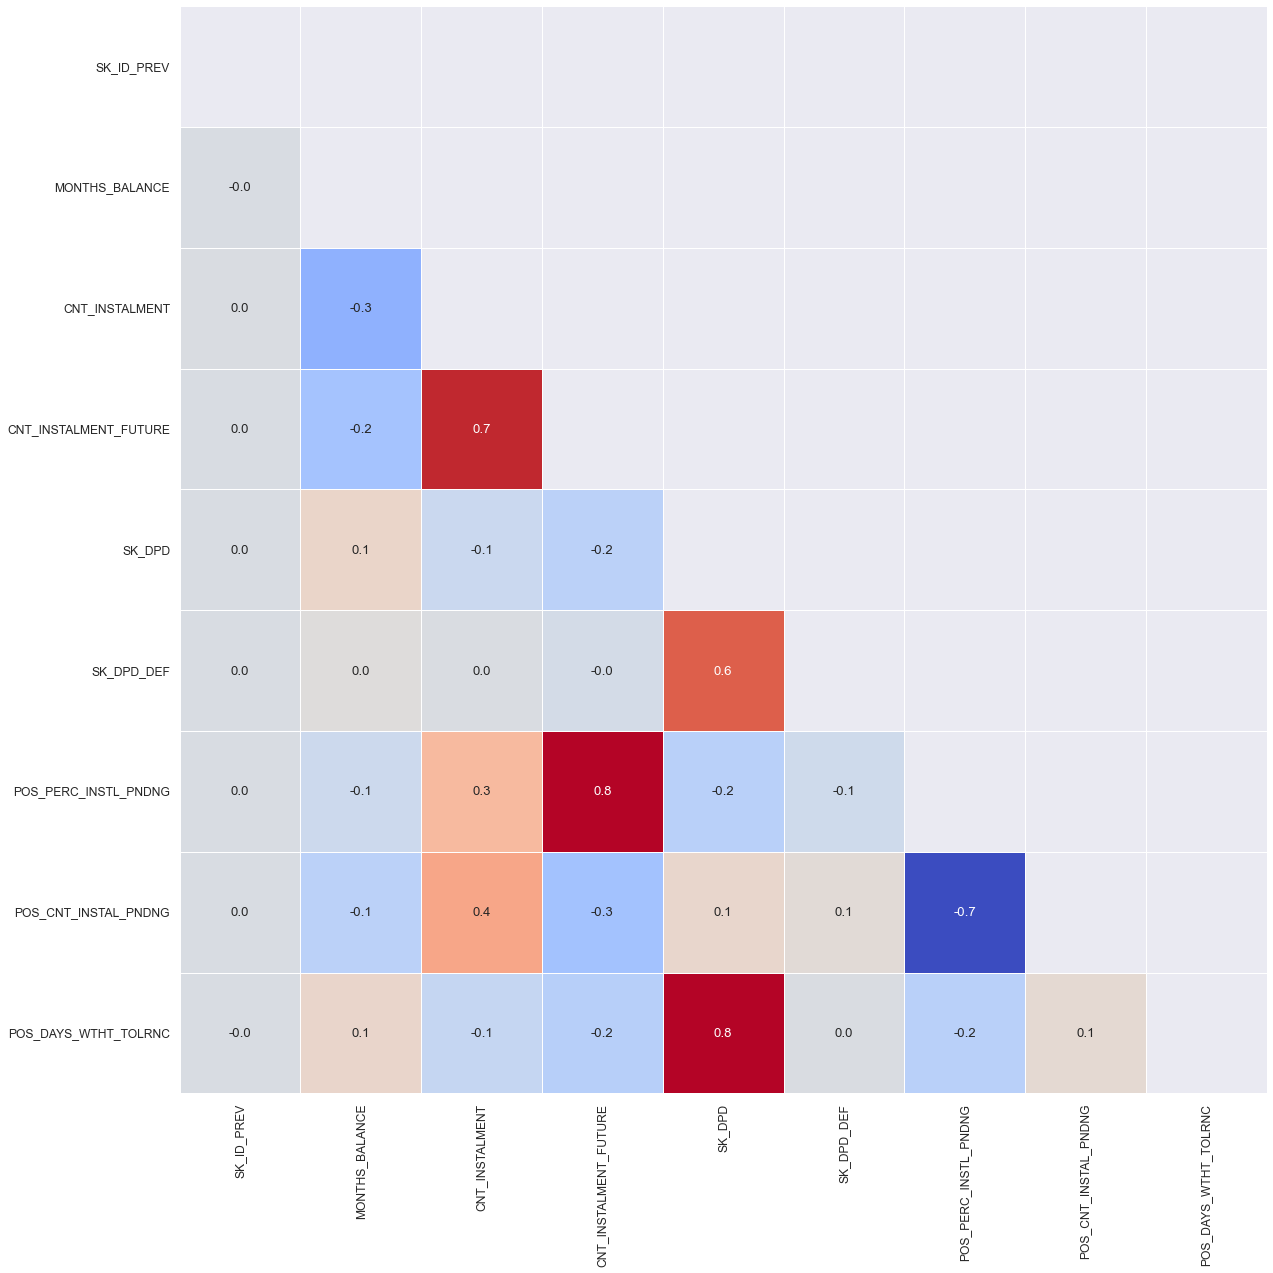

------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
Table under consideration FOR CORRELATION PLOT: CREDIT_CARD_BALANCE


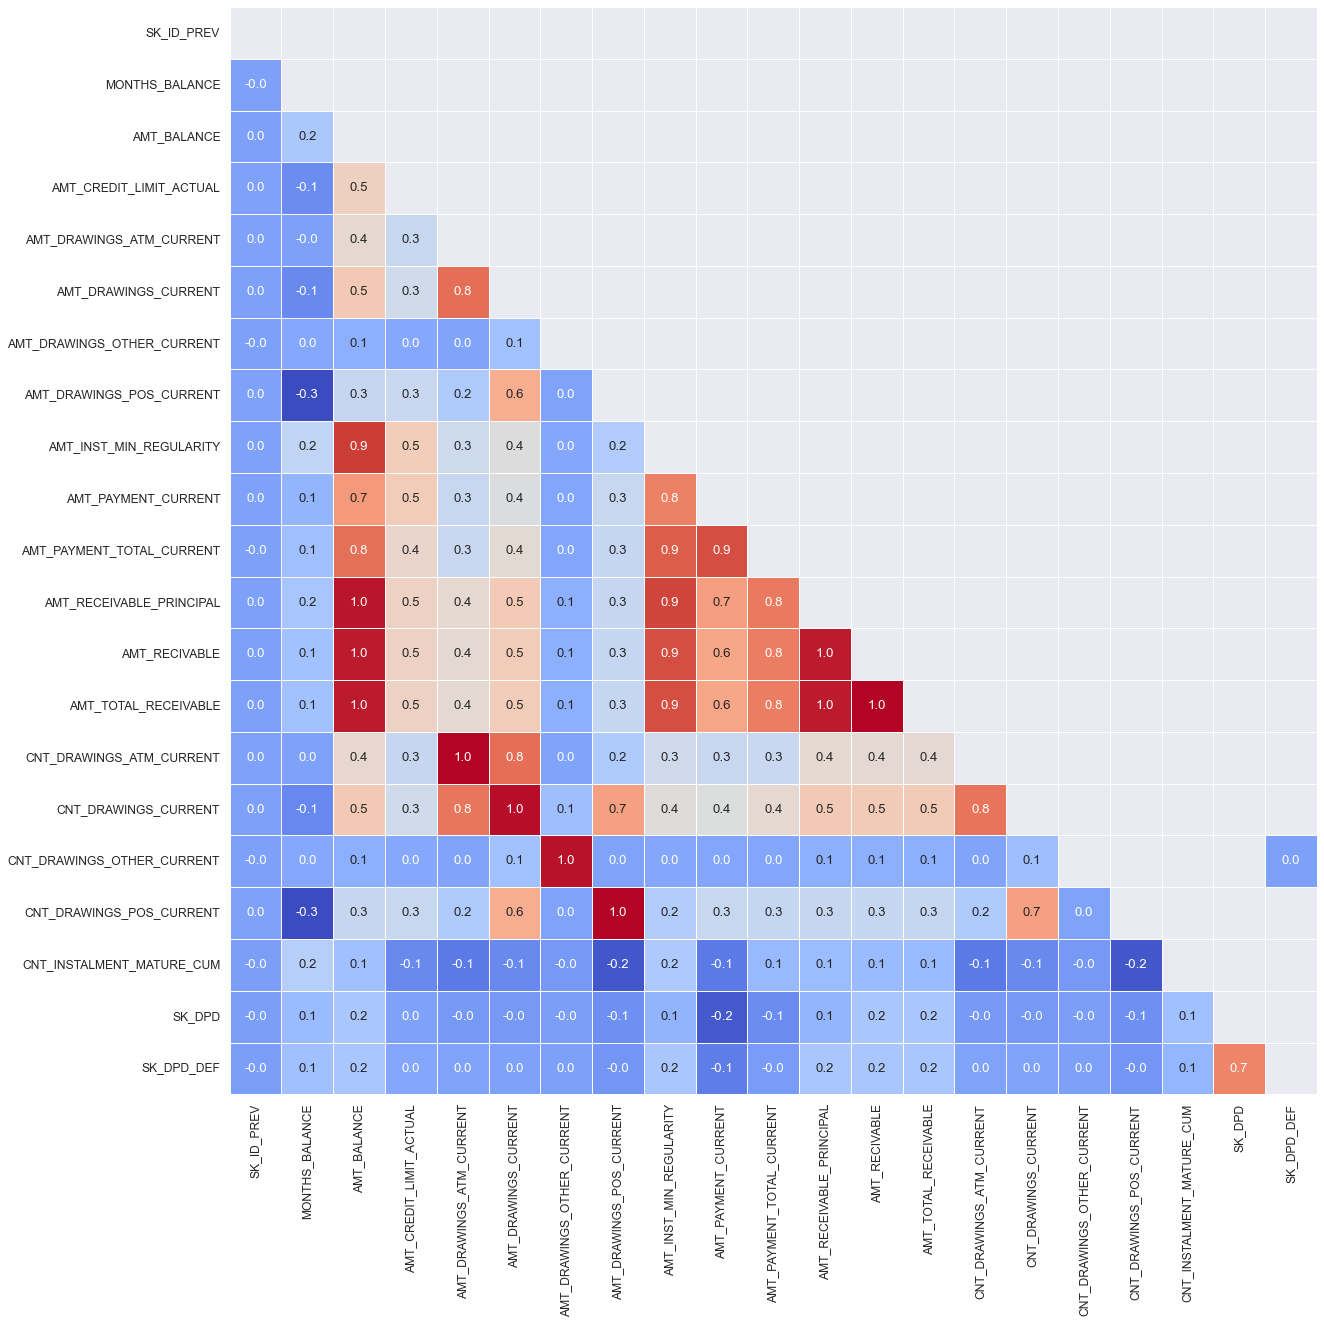

------------------------------------------------------------------------
------------------------------------------------------------------------


In [25]:
for i,ds_name in enumerate(datasets.keys()):
    print("------------------------------------------------------------------------")
    print("Table under consideration FOR CORRELATION PLOT:",ds_name.upper())
    corr_plot(datasets[ds_name], remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman")
    print("------------------------------------------------------------------------")
    print("------------------------------------------------------------------------")
